# Madrid Train Bombing Network Analytics

FOUR kinds of ties linking the individuals involved:
1.   Trust-friendship (contact, kinship, links in the telephone center).
2.   Ties to Al Qaeda and to Osama Bin Laden.
3.   Co-participation in training camps or wars.
4.   Co-participation in previous terrorist attacks (Sept 11, Casablanca).

These four were added together providing a *“strength of connection”* index
that ranges from 1 to 4. 

### Hint

For instance:
* Flush out the most dangerous terrorists;
  * Explain the concept adopted as “most dangerous”
* Detect the most cohesive groups of terrorists;
  * Detect the most influencial terrorist within each group


- Try also **edge_betweenness**


### Import packages and data


In [284]:
# Networks
import igraph as ig
import louvain

# Computation
import numpy as np
np.random.seed(0)
import scipy
import random
random.seed(0)

# Data
import pandas as pd
import csv

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

import sys

import plotly
import plotly.plotly as py

import networkx as nx

In [285]:
g = ig.Graph.Read_Ncol("data/madrid-edges.dat", names=True)
g["name"] = "g"

names = open("data/madrid-names.dat")
lines = names.read().split('\n')

for i in range(len(lines)):
    lines[i] = lines[i].replace('"', '')
    
for i in range(len(g.vs)):
    g.vs[i]["name"] = lines[int(g.vs[i]["name"])-1]
    
g.vs["label"] = g.vs["name"]
    
print(g)

IGRAPH DNW- 64 486 -- g
+ attr: name (g), label (v), name (v), weight (e)
+ edges (vertex names):
           Jamal Zougam -> Mohamed Bekkali, Mohamed Chaoui, Vinay Kholy,
Suresh Kumar, Mohamed Chedadi, Imad Eddin Barakat, Abdelaziz Benyaich, Abu
Abderrahame, Amer Azizi, Abu Musad Alsakaoui, Mohamed Atta, Ramzi Binalshibh,
Mohamed Belfatmi, Said Bahaji, Galeb Kalaje, Abderrahim Zbakh, Naima Oulad
Akcha, Abdelkarim el Mejjati, Basel Ghayoun, S B Abdelmajid Fakhet, Jamal
Ahmidan, Hamid Ahmidan, Abdeluahid Berrak, Said Berrak, Otman El Gnaut, El
Hemir, OM. Othman Abu Qutada, Shakur, Mohamed El Egipcio
        Mohamed Bekkali -> Jamal Zougam, Mohamed Chaoui
         Mohamed Chaoui -> Jamal Zougam, Mohamed Bekkali, Vinay Kholy, Suresh
Kumar, Imad Eddin Barakat, Abdelaziz Benyaich, Abu Abderrahame, Amer Azizi,
Abu Musad Alsakaoui, Mohamed Atta, Ramzi Binalshibh, Mohamed Belfatmi, Said
Bahaji, Galeb Kalaje, Abderrahim Zbakh, Naima Oulad Akcha, Abdelkarim el
Mejjati, Basel Ghayoun, S B Abdelmaj

### General analysis

In [286]:
n = g.vcount()
m = g.ecount()
print('{0} nodes, {1} edges'.format(n, m))

64 nodes, 486 edges


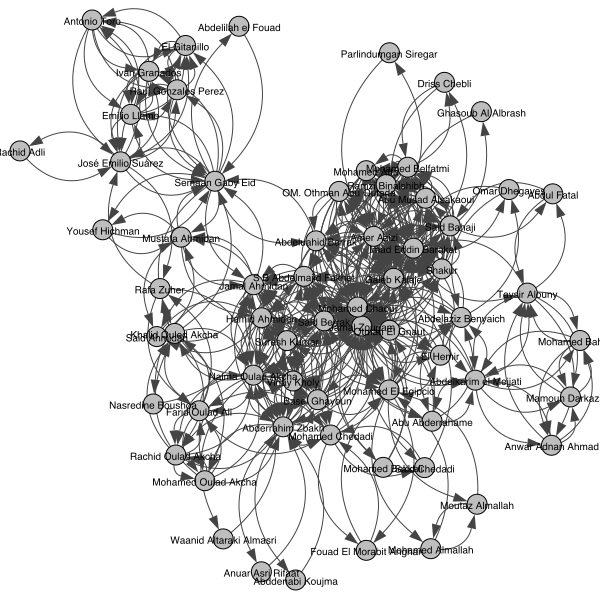

In [287]:
visual_style = {}
visual_style["vertex_label_size"] = 10
visual_style["vertex_color"] = 'gray'
visual_style["vertex_label"] = g.vs["label"]

ig.plot(g,  layout=g.layout("kk"), **visual_style)

## Centrality Analitycs



In [288]:
def normalized_betweenness(graph):
    list_betweenness=list()
    n = graph.vcount()
    for value in graph.betweenness(weights=graph.es["weight"]):
        list_betweenness.append(value/(((n-1)*(n-2))))
    return list_betweenness

def nodes_bound(graph, threshold, measure, plot_name):
    label = graph.vs["label"]
    measure_list = list()
    nodes = list()
    
    directory_name = 'out/' + str(graph["name"]) + '/' + measure + '.npy'
    
    if measure == 'closeness':
        measure_list = graph.closeness(weights=graph.es["weight"])
    elif measure == 'betweenness':
        measure_list =  graph.betweenness(weights=graph.es["weight"])
    elif measure == 'normalized_betweenness':
        measure_list =  normalized_betweenness(graph)
    elif measure == 'pagerank':
        measure_list =  graph.personalized_pagerank(weights=graph.es["weight"])
    elif measure == 'degree':
        measure_list =  [x / (g.vcount()) for x in graph.degree()]
    elif measure == 'eigenvector_centrality':
        measure_list = graph.evcent(weights=graph.es["weight"])
    else:
        print('Function not available.')
    
    np.save(directory_name, measure_list)
    
    for i in range (len(measure_list)):
        if measure_list[i] >= threshold:
            nodes.append((label[i], round(measure_list[i], 3)))
            
    sorted_nodes = sorted(nodes, key = lambda x: float(x[1]))
    
    plt.hist(measure_list, log=True, rwidth=0.9)
    plt.title(measure + ' histogram')
    plt.suptitle(plot_name, y=1.0, fontsize=12)
    plt.savefig('images/' + str(graph["name"]) + '/histogram/' + measure + '.pdf')
    plt.show()
    print('Vertex with the highest ', measure, ': \n', sorted_nodes)
    
    #return sorted_nodes

def import_measure(graph):
    degree = np.load('out/' + str(graph["name"]) + '/degree.npy')
    betweenness = np.load('out/' + str(graph["name"]) + '/normalized_betweenness.npy')
    closeness = np.load('out/' + str(graph["name"]) + '/closeness.npy')
    pagerank = np.load('out/' + str(graph["name"]) + '/pagerank.npy')
    eigenvector = np.load('out/' + str(graph["name"]) + '/eigenvector_centrality.npy')
    
    return degree, betweenness, closeness, pagerank, eigenvector 

In [289]:
def ranking(graph):
    label = graph.vs['label']
    
    degree, betweenness, closeness, pagerank, eigenvector = import_measure(graph)
    
    ranking_Degree = list()
    ranking_Betweenness = list()
    ranking_Closeness = list()
    ranking_Pagerank = list()
    ranking_Eigenvector = list()
    
    for i in range (len(label)):
        ranking_Degree.append((label[i], degree[i]))
        ranking_Betweenness.append((label[i], betweenness[i]))
        ranking_Closeness.append((label[i], closeness[i]))
        ranking_Pagerank.append((label[i], pagerank[i]))
        ranking_Eigenvector.append((label[i], eigenvector[i]))
        
    ranking_Degree = sorted(ranking_Degree, key = lambda x: float(x[1]), reverse=True)
    ranking_Betweenness = sorted(ranking_Betweenness, key = lambda x: float(x[1]), reverse=True)
    ranking_Closeness = sorted(ranking_Closeness, key = lambda x: float(x[1]), reverse=True)
    ranking_Pagerank = sorted(ranking_Pagerank, key = lambda x: float(x[1]), reverse=True)
    ranking_Eigenvector = sorted(ranking_Eigenvector, key = lambda x: float(x[1]), reverse=True)
    
    return ranking_Degree[:5], ranking_Betweenness[:5], ranking_Closeness[:5], ranking_Pagerank[:5], ranking_Eigenvector[:5]
    
def unsorted_ranking_person(graph):
    degree, betweenness, closeness, pagerank, eigenvector = ranking(graph)
    
    ranking_Degree = list()
    ranking_Betweenness = list()
    ranking_Closeness = list()
    ranking_Pagerank = list()
    ranking_Eigenvector = list()
    
    for i in range(len(ranking(graph))):
        ranking_Degree.append(degree[i][0])
        ranking_Betweenness.append(betweenness[i][0])
        ranking_Closeness.append(closeness[i][0])
        ranking_Pagerank.append(pagerank[i][0])
        ranking_Eigenvector.append(eigenvector[i][0])
        
    return ranking_Degree, ranking_Betweenness, ranking_Closeness, ranking_Pagerank, ranking_Eigenvector

In [290]:
def plot_with_ranking(graph, measure):
    if measure == "degree":
        rank = unsorted_ranking_person(graph)[0]
    if measure == "normalized_betweenness":
        rank = unsorted_ranking_person(graph)[1]
    if measure == "closeness":
        rank = unsorted_ranking_person(graph)[2]
    if measure == "pagerank":
        rank = unsorted_ranking_person(graph)[3]
    if measure == "eigenvector_centrality":
        rank = unsorted_ranking_person(graph)[4]
        
    visual_style = {}
    visual_style["vertex_label_size"] = 10
    visual_style["vertex_size"] = [30 if (v in rank) else 15 for v in graph.vs["label"]]
    visual_style["vertex_color"] = ['red' if (v in rank) else 'dark gray' for v in graph.vs["label"]]
    visual_style["vertex_label"] = graph.vs["label"]
    layout = graph.layout("kk")
    
    output_dir = 'images/' + str(graph["name"]) + '/ranking/' + measure + '.pdf'
    return ig.plot(graph, output_dir, layout = layout, **visual_style)

def personalized_plots(graph, measure, threshold, name):
    nodes_bound(graph, threshold, measure, name)
    return plot_with_ranking(graph, measure)

### Shortest path 

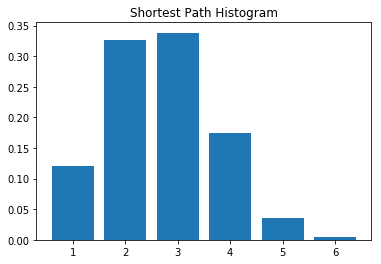

In [291]:
hist = g.path_length_hist(directed=True)

bins = []
values = []

for bin in hist.bins():
    values.append(bin[2])
    bins.append(bin[0])

bins = np.array(bins)
bins = bins.astype(int)
values = np.array(values)

values = values / np.sum(values)

plt.bar(bins, values)
plt.xticks(bins, bins)
plt.title("Shortest Path Histogram")
plt.show()

### Degree centrality

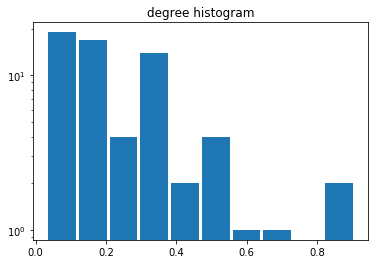

Vertex with the highest  degree : 
 [('Mohamed Chaoui', 0.844), ('Jamal Zougam', 0.906)]


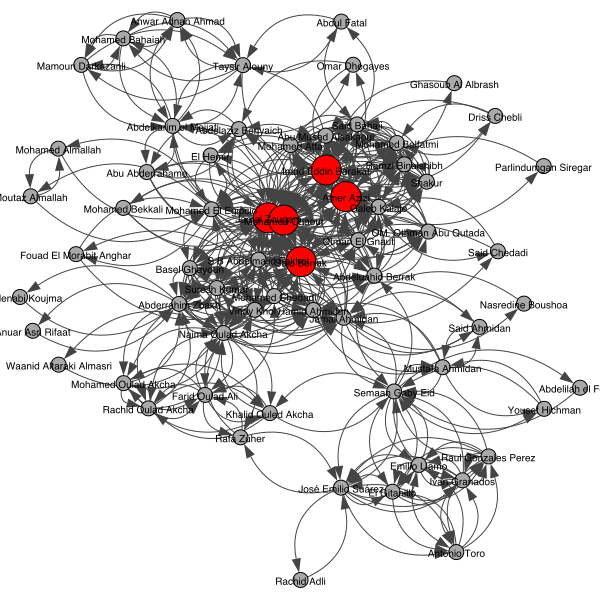

In [292]:
personalized_plots(g, 'degree', 0.8, '')

### Betweenness centrality

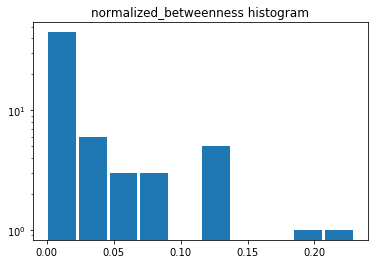

Vertex with the highest  normalized_betweenness : 
 [('Mohamed Chaoui', 0.191), ('Semaan Gaby Eid', 0.23)]


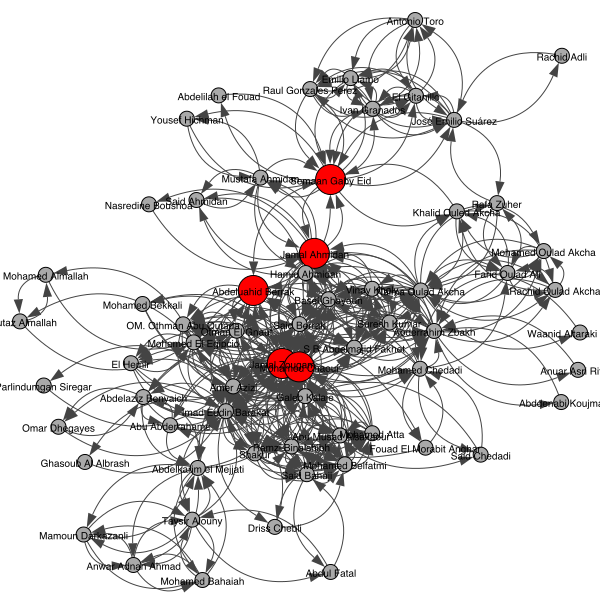

In [293]:
personalized_plots(g, 'normalized_betweenness', 0.15, '')

### Closeness centrality

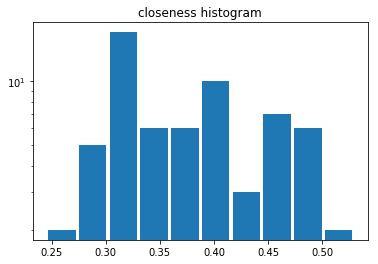

Vertex with the highest  closeness : 
 [('Basel Ghayoun', 0.463), ('Abderrahim Zbakh', 0.474), ('S B Abdelmajid Fakhet', 0.474), ('Naima Oulad Akcha', 0.481), ('Abdeluahid Berrak', 0.485), ('Said Berrak', 0.485), ('Jamal Ahmidan', 0.496), ('Jamal Zougam', 0.516), ('Mohamed Chaoui', 0.529)]


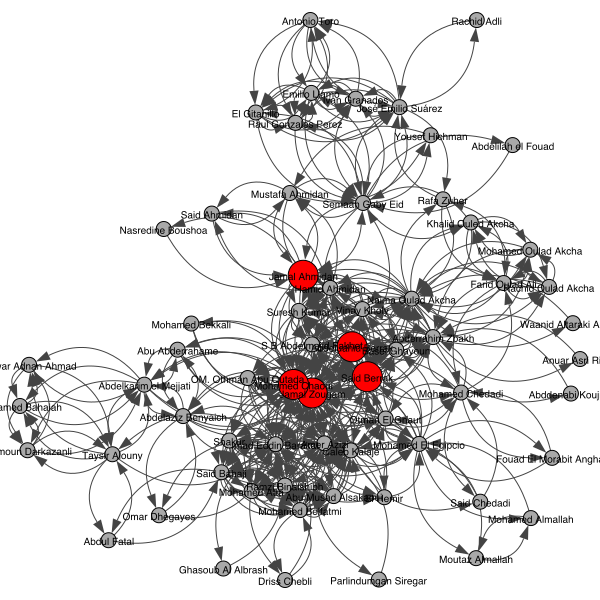

In [294]:
personalized_plots(g, 'closeness', 0.46, '')

### Pagerank centrality

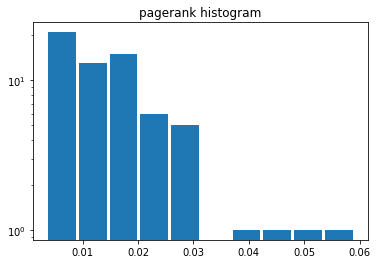

Vertex with the highest  pagerank : 
 [('Mohamed Chaoui', 0.047), ('Imad Eddin Barakat', 0.049), ('Jamal Zougam', 0.059)]


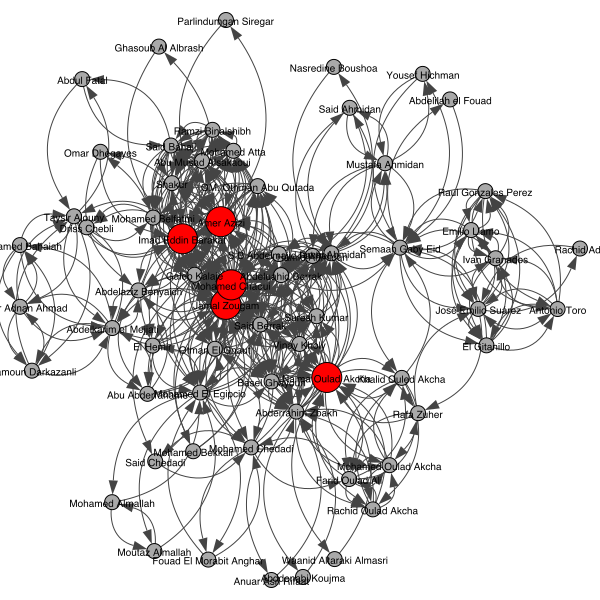

In [295]:
personalized_plots(g, 'pagerank', 0.038, '')

### Eigenvector centrality

/Users/Giorgia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

Weighted directed graph in eigenvector centrality at centrality.c:362



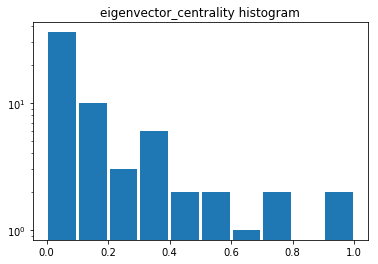

Vertex with the highest  eigenvector_centrality : 
 [('Imad Eddin Barakat', 0.904), ('Jamal Zougam', 1.0)]


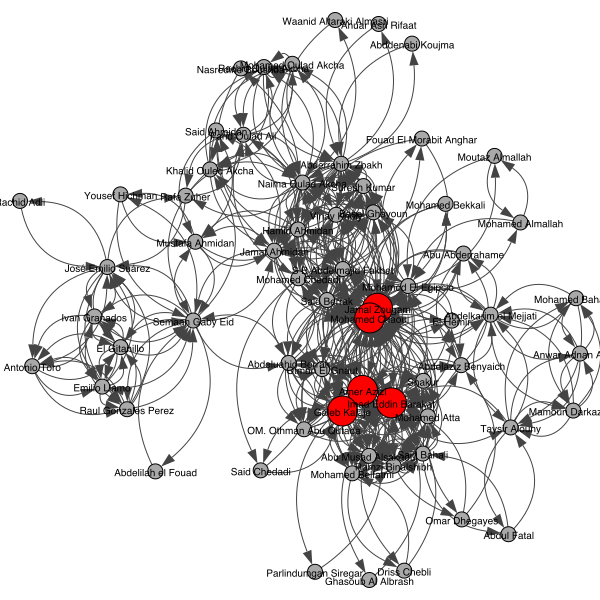

In [296]:
personalized_plots(g, 'eigenvector_centrality', 0.8, '')

## Community Detection

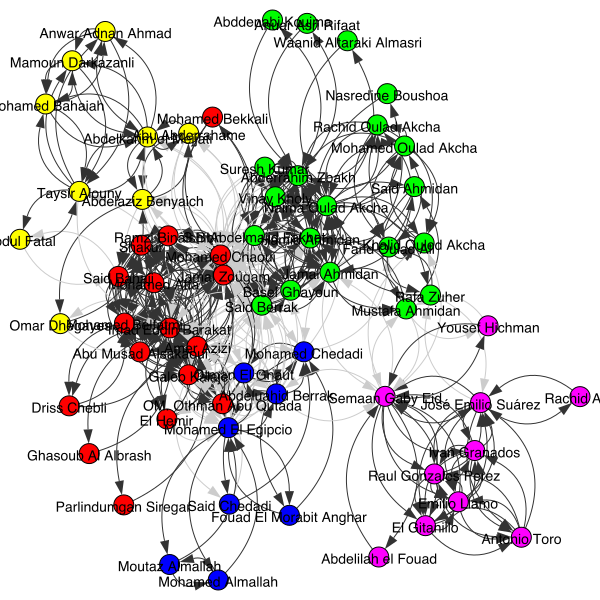

In [297]:
partition = g.community_optimal_modularity(weights=g.es["weight"])
ig.plot(partition, 'images/community-partition.pdf')

In [298]:
partition.modularity

0.43768547859765483

In [299]:
partition.summary()

'Clustering with 64 elements and 5 clusters'

In [300]:
partition.sizes()

[17, 20, 8, 9, 10]

In [301]:
community_1 = partition[0]
community_2 = partition[1]
community_3 = partition[2]
community_4 = partition[3]
community_5 = partition[4]

print('\n', 'lunghezza community 1: ', len(community_1), 
      '\n', 'lunghezza community 2: ', len(community_2), 
      '\n', 'lunghezza community 3: ', len(community_3), 
      '\n', 'lunghezza community 4: ', len(community_4), 
      '\n', 'lunghezza community 5: ', len(community_5))


 lunghezza community 1:  17 
 lunghezza community 2:  20 
 lunghezza community 3:  8 
 lunghezza community 4:  9 
 lunghezza community 5:  10


In [302]:
sg1 = g.subgraph(community_1)
sg1["name"] = "sg1"
sg2 = g.subgraph(community_2)
sg2["name"] = "sg2"
sg3 = g.subgraph(community_3)
sg3["name"] = "sg3"
sg4 = g.subgraph(community_4)
sg4["name"] = "sg4"
sg5 = g.subgraph(community_5)
sg5["name"] = "sg5"

vc1 = sg1.vcount()
ec1 = sg1.ecount()

vc2 = sg2.vcount()
ec2 = sg2.ecount()

vc3 = sg3.vcount()
ec3 = sg3.ecount()

vc4 = sg4.vcount()
ec4 = sg4.ecount()

vc5 = sg5.vcount()
ec5 = sg5.ecount()

print('\n', 'Il sottografo 1 ha: {0} nodi, {1} archi.'.format(vc1, ec1), 
      '\n', 'Il sottografo 2 ha: {0} nodi, {1} archi.'.format(vc2, ec2), 
      '\n', 'Il sottografo 3 ha: {0} nodi, {1} archi.'.format(vc3, ec3), 
      '\n', 'Il sottografo 4 ha: {0} nodi, {1} archi.'.format(vc4, ec4), 
      '\n', 'Il sottografo 3 ha: {0} nodi, {1} archi.'.format(vc5, ec5))


 Il sottografo 1 ha: 17 nodi, 138 archi. 
 Il sottografo 2 ha: 20 nodi, 118 archi. 
 Il sottografo 3 ha: 8 nodi, 22 archi. 
 Il sottografo 4 ha: 9 nodi, 30 archi. 
 Il sottografo 3 ha: 10 nodi, 46 archi.


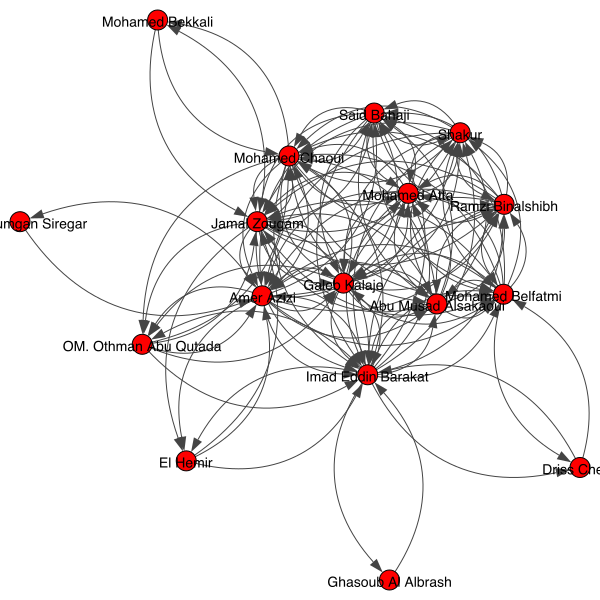

In [303]:
ig.plot(sg1, 'images/sg1/Community1.pdf')

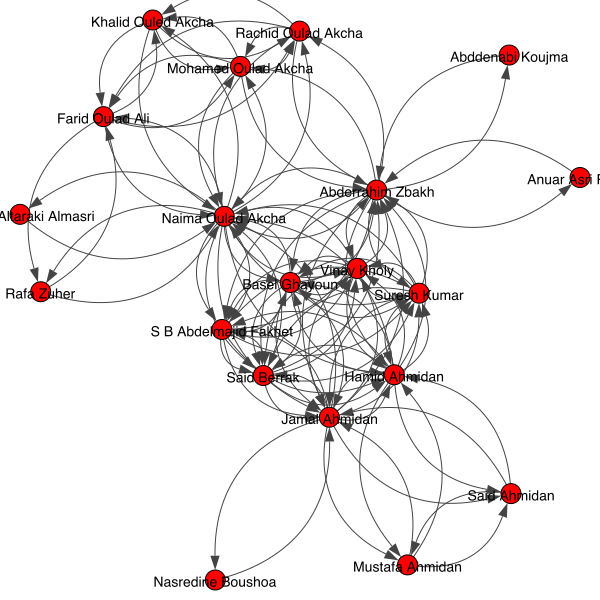

In [304]:
ig.plot(sg2, 'images/sg2/Community2.pdf')

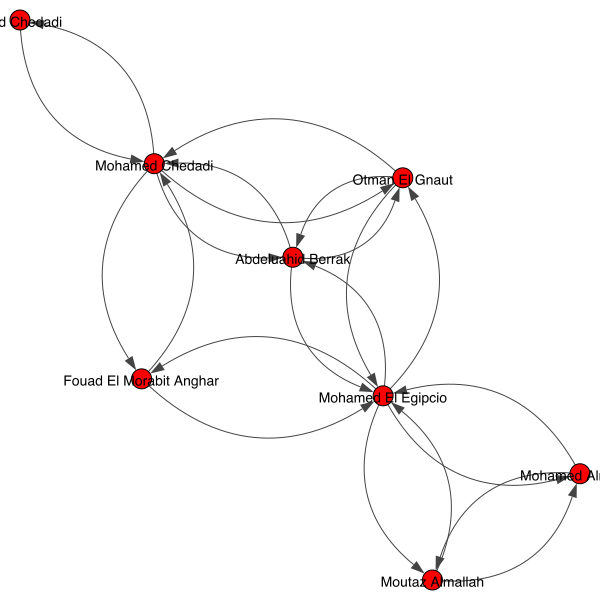

In [305]:
ig.plot(sg3, 'images/sg3/Community3.pdf')

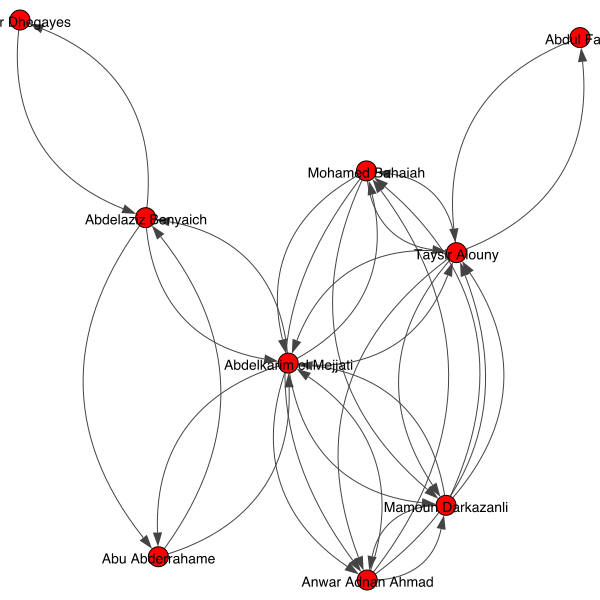

In [306]:
ig.plot(sg4, 'images/sg4/Community4.pdf')

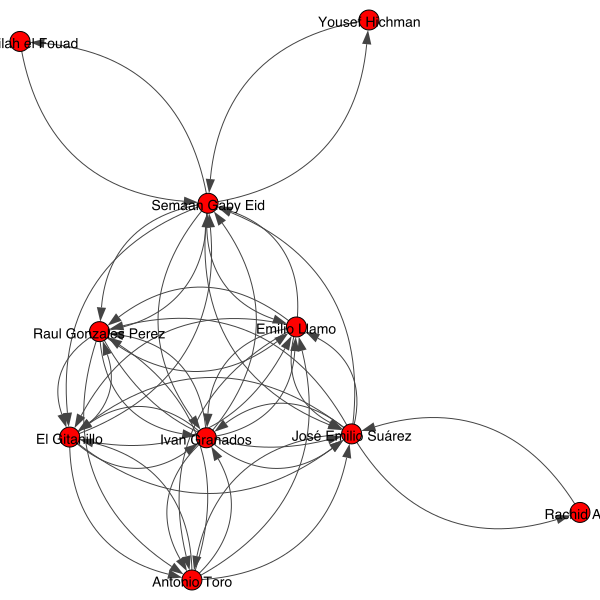

In [307]:
ig.plot(sg5, 'images/sg5/Community5.pdf')

## Community 1 - Centrality Analitycs

### Degree centrality

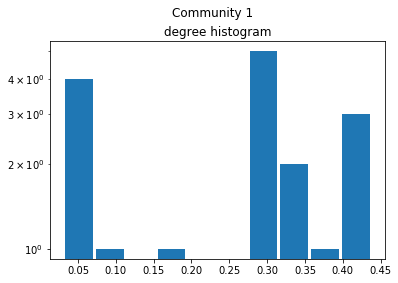

Vertex with the highest  degree : 
 [('Mohamed Chaoui', 0.375), ('Jamal Zougam', 0.406), ('Amer Azizi', 0.406), ('Imad Eddin Barakat', 0.438)]


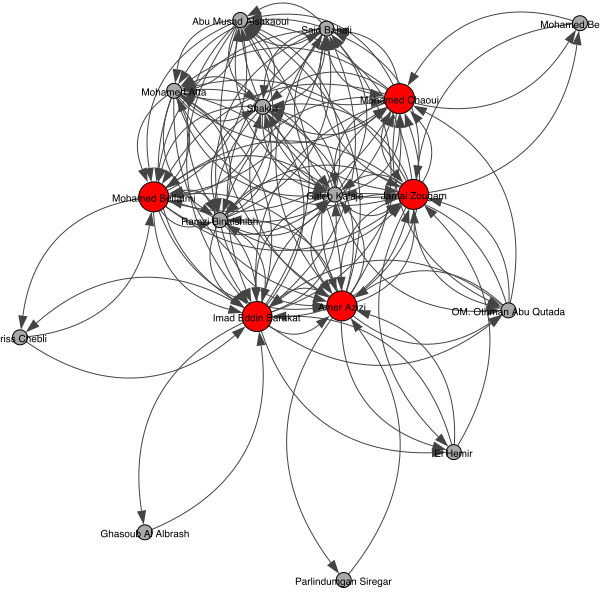

In [308]:
personalized_plots(sg1, 'degree', 0.35, 'Community 1')

### Betweenness centrality

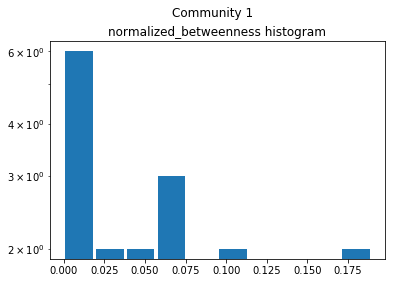

Vertex with the highest  normalized_betweenness : 
 [('Amer Azizi', 0.177), ('Imad Eddin Barakat', 0.189)]


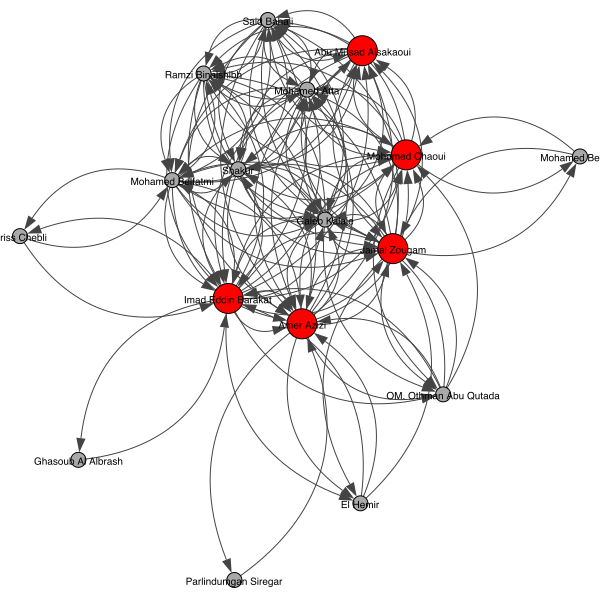

In [309]:
personalized_plots(sg1, 'normalized_betweenness', 0.15, 'Community 1')

### Closeness centrality

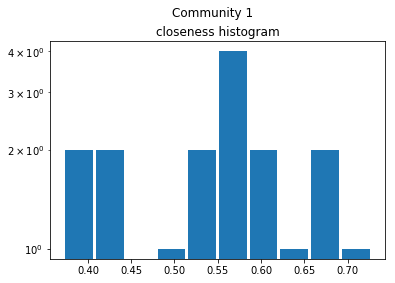

Vertex with the highest  closeness : 
 [('Mohamed Atta', 0.667), ('Shakur', 0.667), ('Abu Musad Alsakaoui', 0.727)]


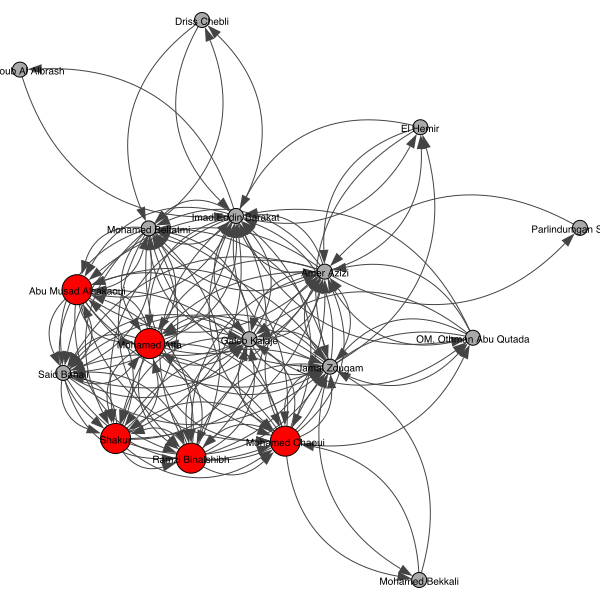

In [310]:
personalized_plots(sg1, 'closeness', 0.65, 'Community 1')

### Pagerank centrality

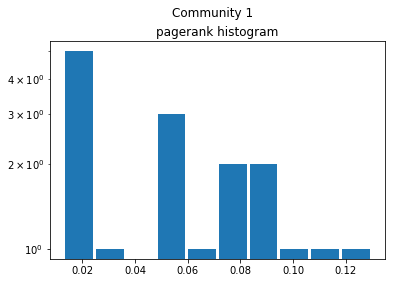

Vertex with the highest  pagerank : 
 [('Amer Azizi', 0.102), ('Jamal Zougam', 0.115), ('Imad Eddin Barakat', 0.13)]


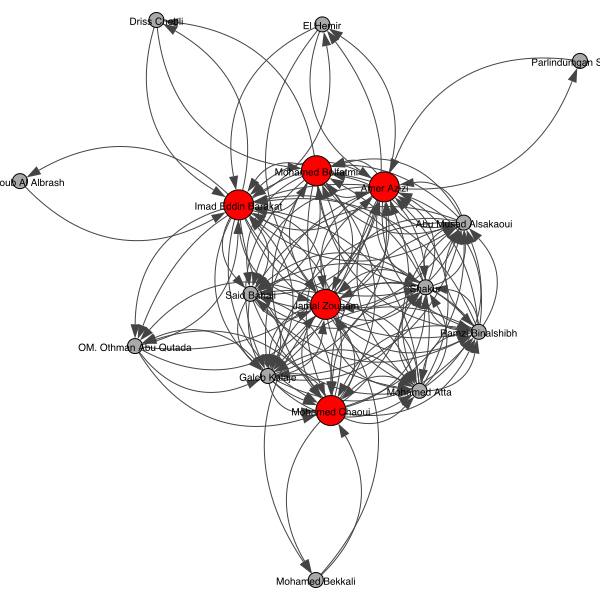

In [311]:
personalized_plots(sg1, 'pagerank', 0.09, 'Community 1')

### Eigenvector centrality

/Users/Giorgia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

Weighted directed graph in eigenvector centrality at centrality.c:362



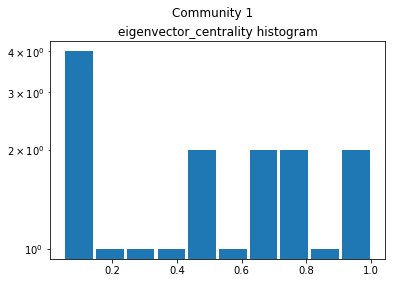

Vertex with the highest  eigenvector_centrality : 
 [('Amer Azizi', 0.85), ('Jamal Zougam', 0.996), ('Imad Eddin Barakat', 1.0)]


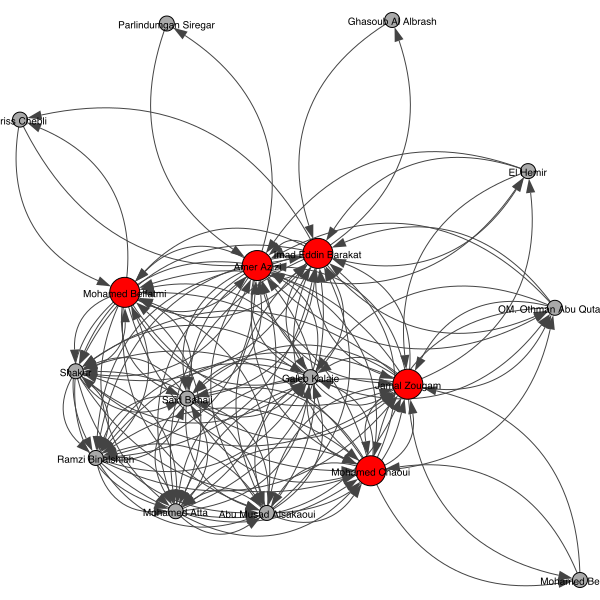

In [312]:
personalized_plots(sg1, 'eigenvector_centrality', 0.8, 'Community 1')

## Community 2 - Centrality Analitycs

### Degree centrality

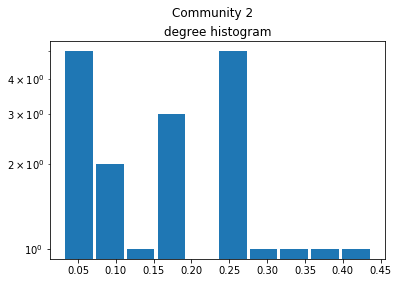

Vertex with the highest  degree : 
 [('Hamid Ahmidan', 0.312), ('Jamal Ahmidan', 0.344), ('Abderrahim Zbakh', 0.375), ('Naima Oulad Akcha', 0.438)]


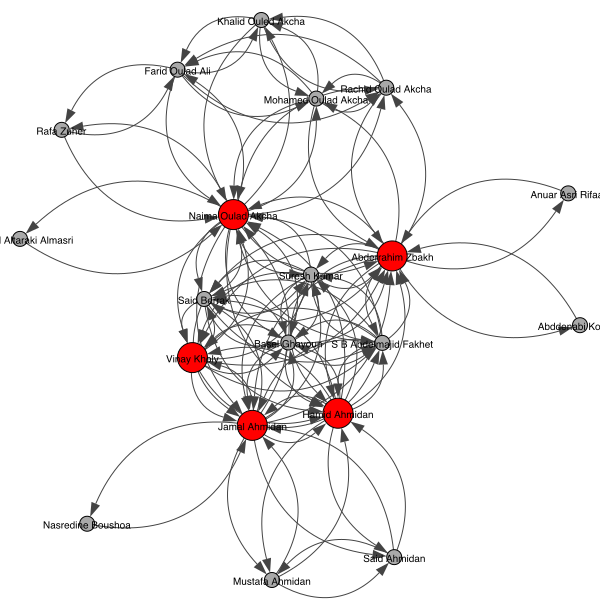

In [313]:
personalized_plots(sg2, 'degree', 0.26, 'Community 2')

### Betweenness centrality

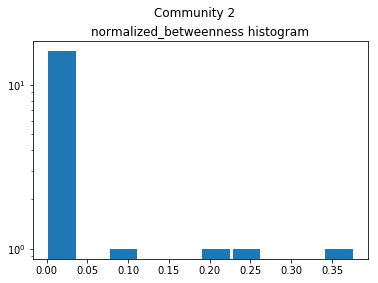

Vertex with the highest  normalized_betweenness : 
 [('Naima Oulad Akcha', 0.377)]


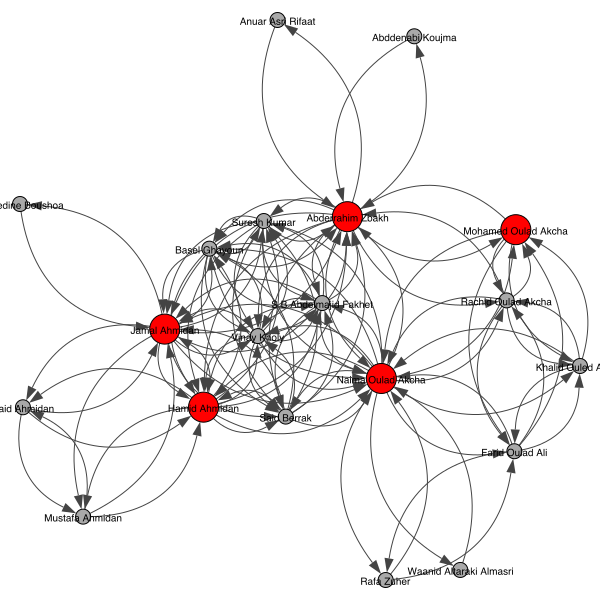

In [314]:
personalized_plots(sg2, 'normalized_betweenness', 0.3, 'Community 2')

### Closeness centrality

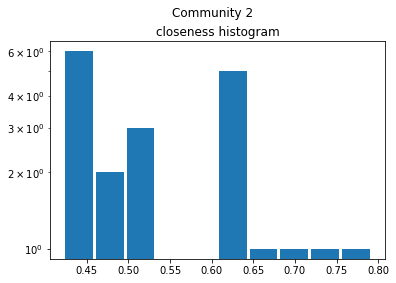

Vertex with the highest  closeness : 
 [('Hamid Ahmidan', 0.679), ('Jamal Ahmidan', 0.704), ('Abderrahim Zbakh', 0.731), ('Naima Oulad Akcha', 0.792)]


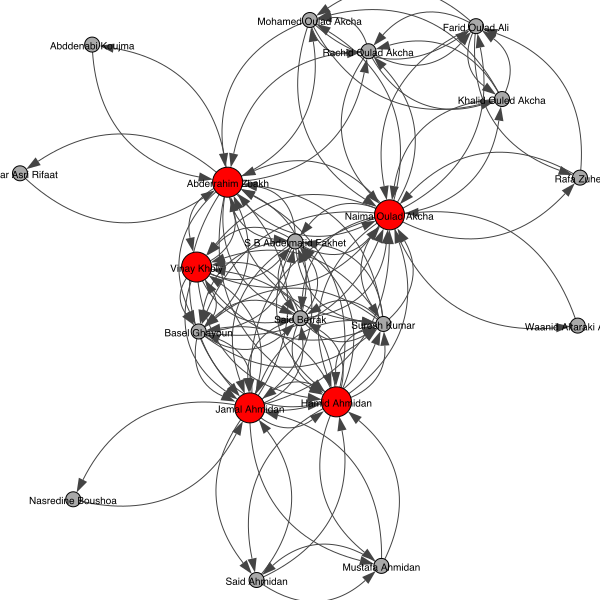

In [315]:
personalized_plots(sg2, 'closeness', 0.65, 'Community 2')

### Pagerank centrality

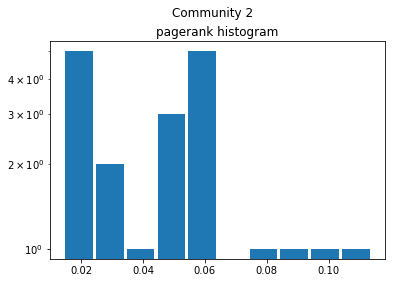

Vertex with the highest  pagerank : 
 [('Hamid Ahmidan', 0.077), ('Jamal Ahmidan', 0.089), ('Abderrahim Zbakh', 0.1), ('Naima Oulad Akcha', 0.114)]


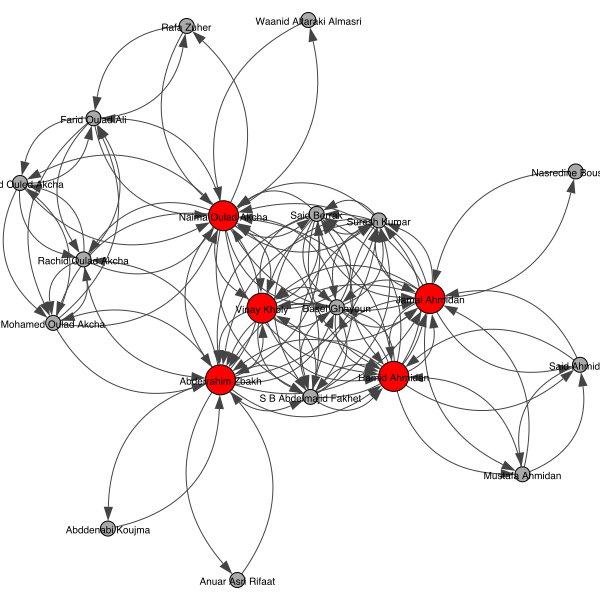

In [316]:
personalized_plots(sg2, 'pagerank', 0.07, 'Community 2')

### Eigenvector centrality

/Users/Giorgia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

Weighted directed graph in eigenvector centrality at centrality.c:362



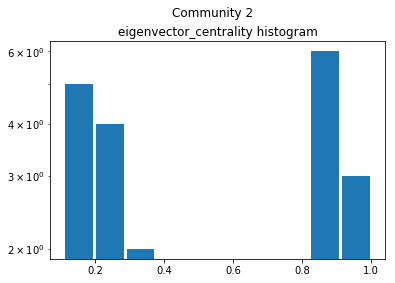

Vertex with the highest  eigenvector_centrality : 
 [('Vinay Kholy', 0.853), ('Suresh Kumar', 0.853), ('Basel Ghayoun', 0.853), ('S B Abdelmajid Fakhet', 0.853), ('Said Berrak', 0.853), ('Hamid Ahmidan', 0.906), ('Jamal Ahmidan', 0.917), ('Abderrahim Zbakh', 0.946), ('Naima Oulad Akcha', 1.0)]


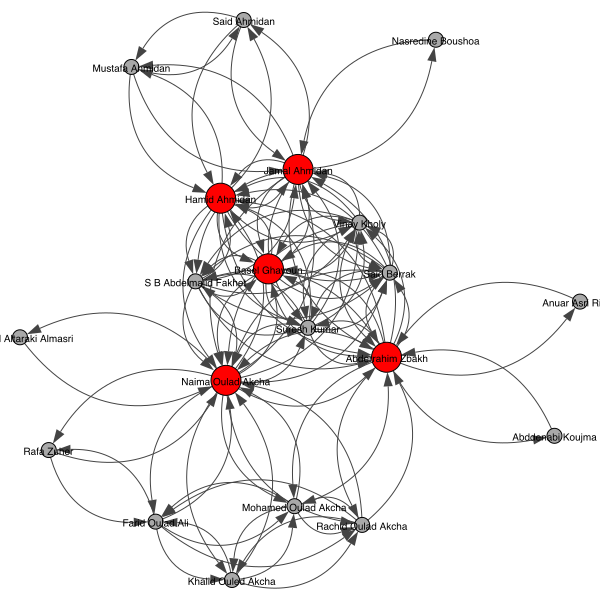

In [317]:
personalized_plots(sg2, 'eigenvector_centrality', 0.8, 'Community 2')

## Community 3 - Centrality Analitycs

### Degree centrality

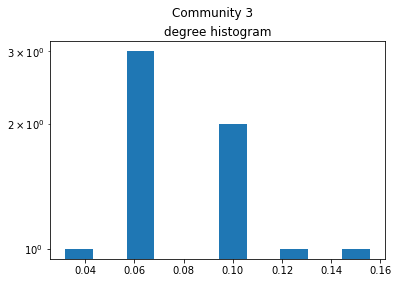

Vertex with the highest  degree : 
 [('Mohamed Chedadi', 0.125), ('Mohamed El Egipcio', 0.156)]


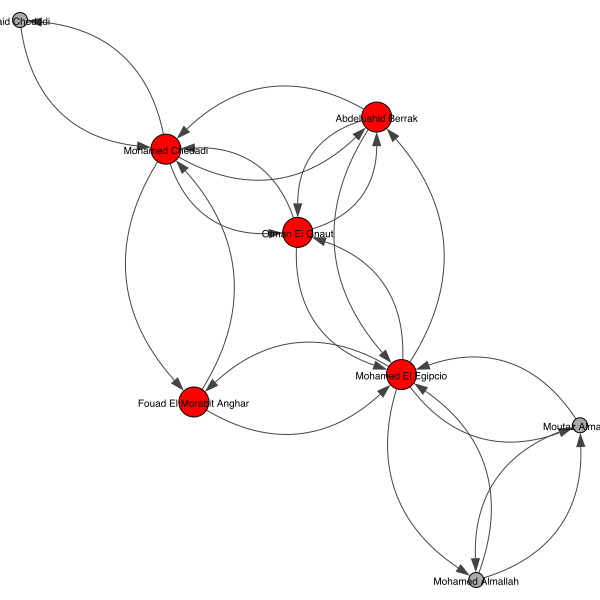

In [318]:
personalized_plots(sg3, 'degree', 0.12, 'Community 3')

### Betweenness centrality

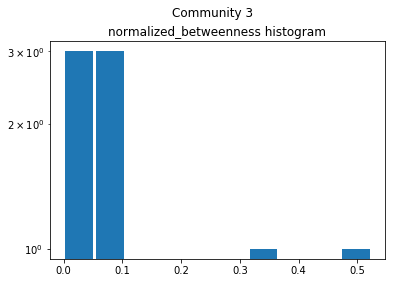

Vertex with the highest  normalized_betweenness : 
 [('Mohamed Chedadi', 0.333), ('Mohamed El Egipcio', 0.524)]


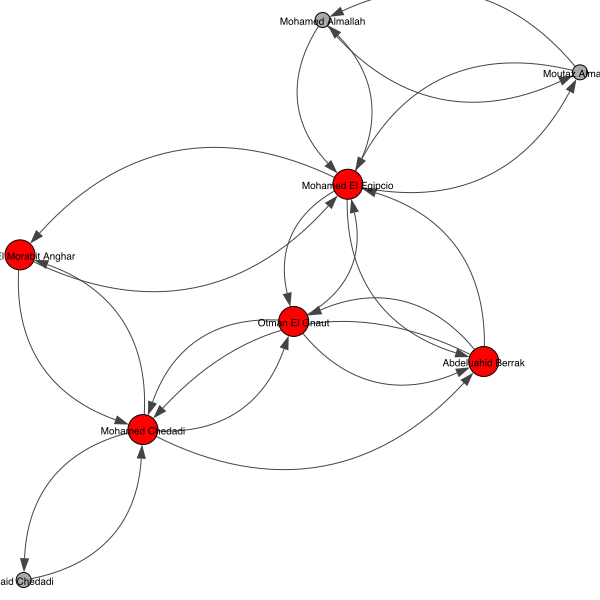

In [319]:
personalized_plots(sg3, 'normalized_betweenness', 0.3, 'Community 3')

### Closeness centrality

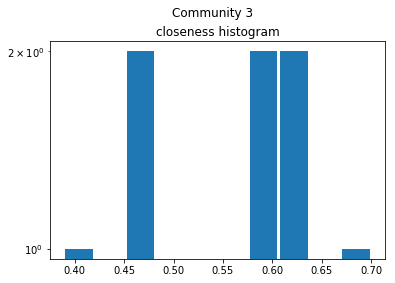

Vertex with the highest  closeness : 
 [('Mohamed Chedadi', 0.583), ('Fouad El Morabit Anghar', 0.583), ('Abdeluahid Berrak', 0.636), ('Otman El Gnaut', 0.636), ('Mohamed El Egipcio', 0.7)]


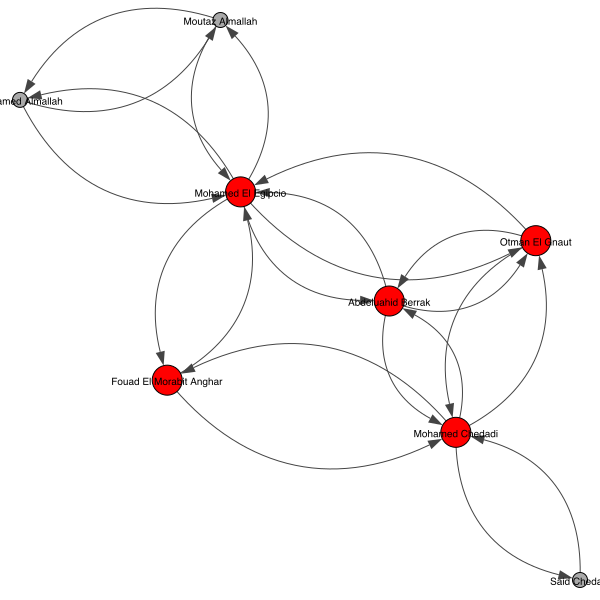

In [320]:
personalized_plots(sg3, 'closeness', 0.55, 'Community 3')

### Pagerank centrality

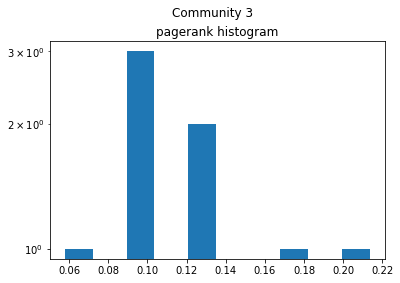

Vertex with the highest  pagerank : 
 [('Mohamed Chedadi', 0.181), ('Mohamed El Egipcio', 0.214)]


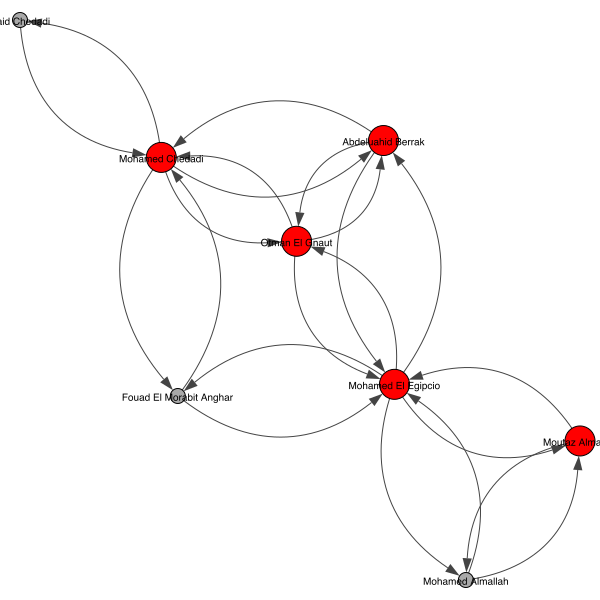

In [321]:
personalized_plots(sg3, 'pagerank', 0.15, 'Community 3')

### Eigenvector centrality

/Users/Giorgia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

Weighted directed graph in eigenvector centrality at centrality.c:362



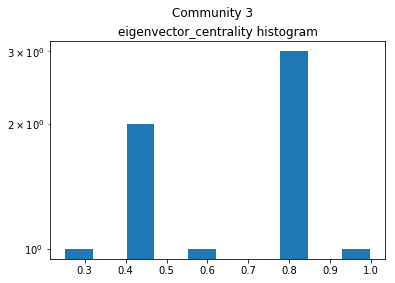

Vertex with the highest  eigenvector_centrality : 
 [('Mohamed Chedadi', 0.784), ('Abdeluahid Berrak', 0.829), ('Otman El Gnaut', 0.829), ('Mohamed El Egipcio', 1.0)]


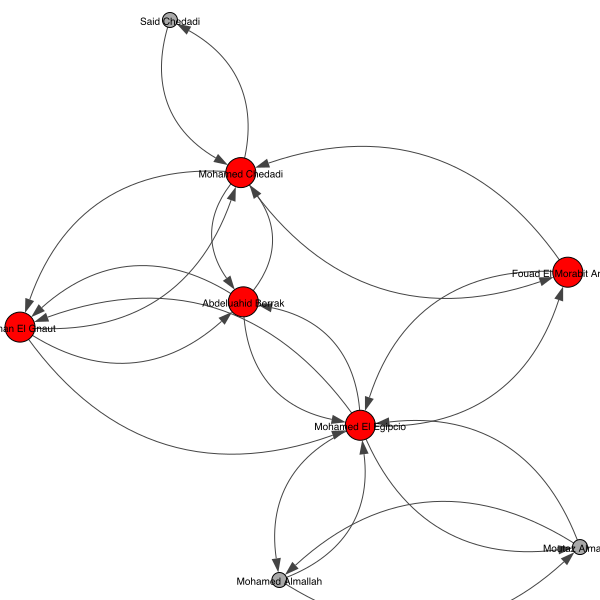

In [322]:
personalized_plots(sg3, 'eigenvector_centrality', 0.7, 'Community 3')

## Community 4 - Centrality Analitycs

### Degree centrality

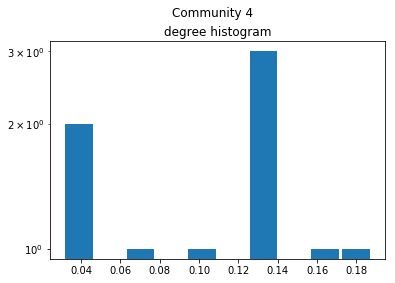

Vertex with the highest  degree : 
 [('Taysir Alouny', 0.156), ('Abdelkarim el Mejjati', 0.188)]


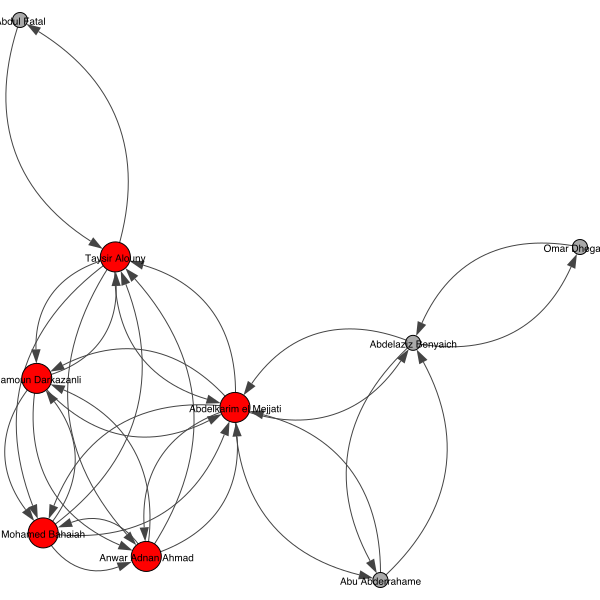

In [323]:
personalized_plots(sg4, 'degree', 0.15, 'Community 4')

### Betweenness centrality

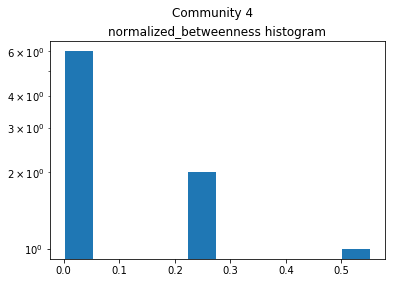

Vertex with the highest  normalized_betweenness : 
 [('Abdelkarim el Mejjati', 0.554)]


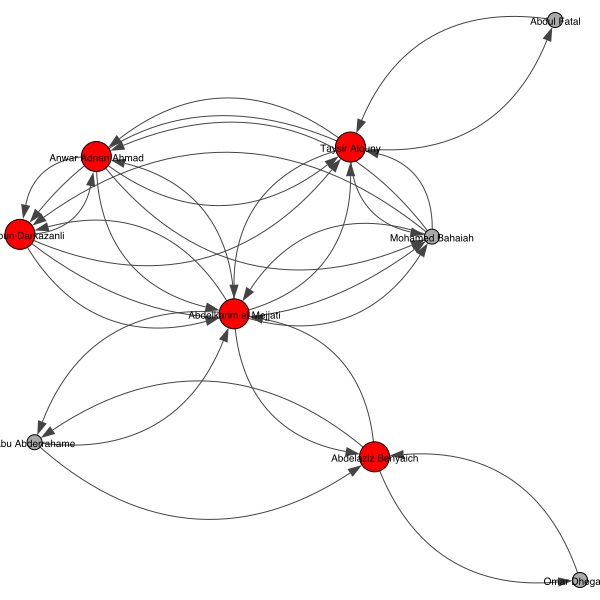

In [324]:
personalized_plots(sg4, 'normalized_betweenness', 0.4, 'Community 4')

### Closeness centrality

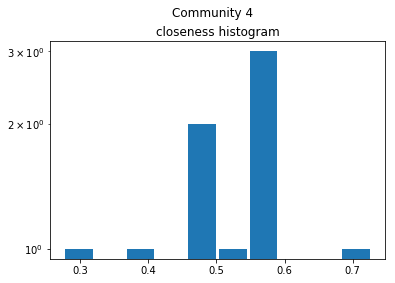

Vertex with the highest  closeness : 
 [('Abdelkarim el Mejjati', 0.727)]


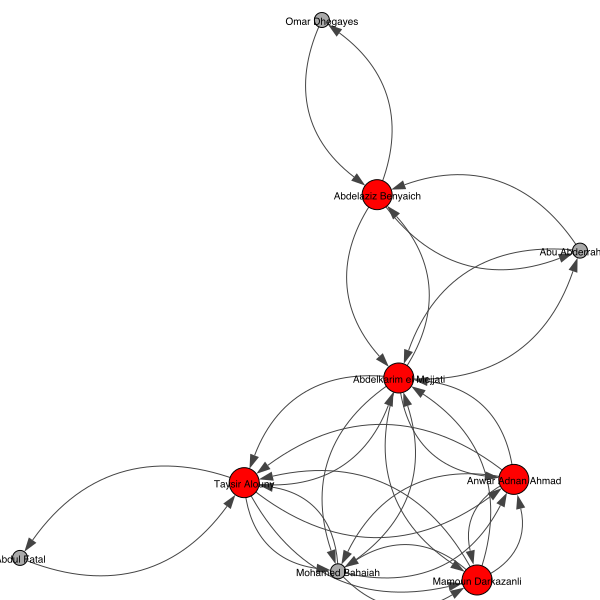

In [325]:
personalized_plots(sg4, 'closeness', 0.6, 'Community 4')

### Pagerank centrality

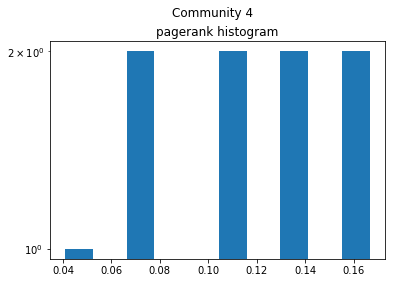

Vertex with the highest  pagerank : 
 [('Abdelaziz Benyaich', 0.131), ('Mohamed Bahaiah', 0.135), ('Abdelkarim el Mejjati', 0.167), ('Taysir Alouny', 0.167)]


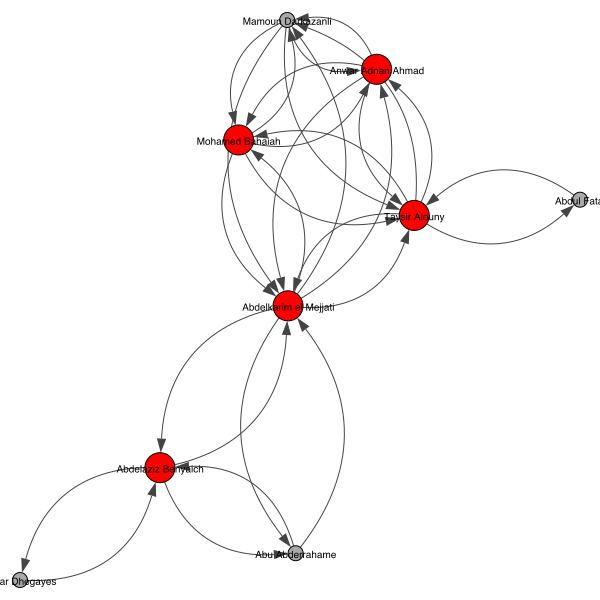

In [326]:
personalized_plots(sg4, 'pagerank', 0.12, 'Community 4')

### Eigenvector centrality

/Users/Giorgia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

Weighted directed graph in eigenvector centrality at centrality.c:362



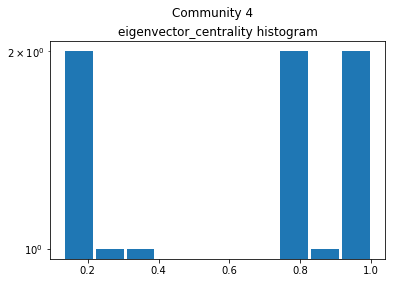

Vertex with the highest  eigenvector_centrality : 
 [('Anwar Adnan Ahmad', 0.789), ('Mamoun Darkazanli', 0.789), ('Abdelkarim el Mejjati', 0.89), ('Mohamed Bahaiah', 0.967), ('Taysir Alouny', 1.0)]


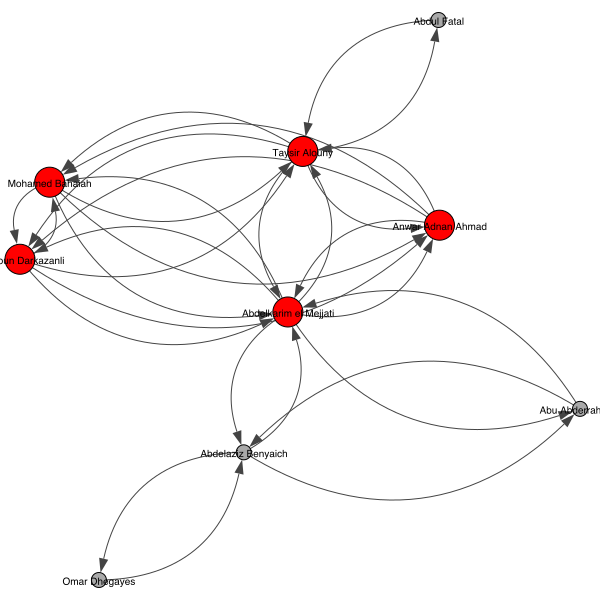

In [327]:
personalized_plots(sg4, 'eigenvector_centrality', 0.6, 'Community 4')

## Community 5 - Centrality Analitycs

### Degree centrality

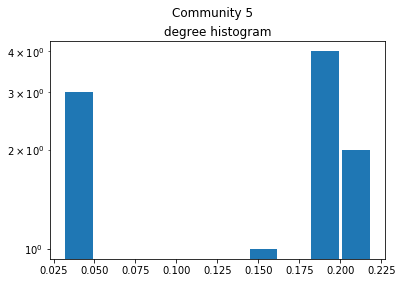

Vertex with the highest  degree : 
 [('Emilio Llamo', 0.188), ('Ivan Granados', 0.188), ('Raul Gonzales Perez', 0.188), ('El Gitanillo', 0.188), ('José Emilio Suárez', 0.219), ('Semaan Gaby Eid', 0.219)]


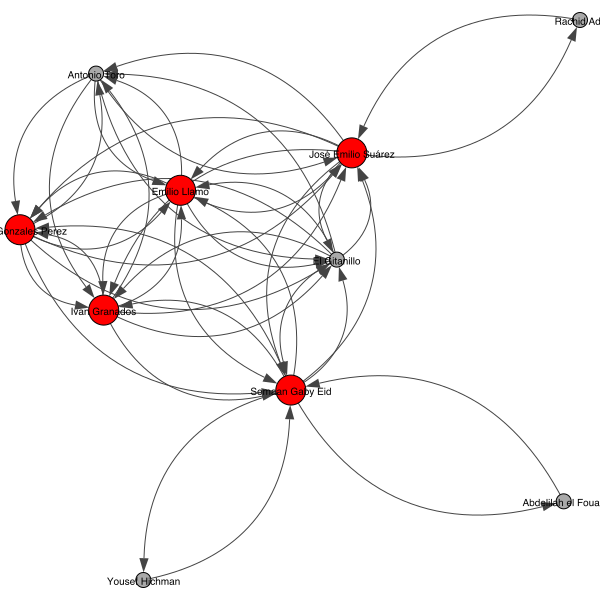

In [328]:
personalized_plots(sg5, 'degree', 0.16, 'Community 5')

### Betweenness centrality

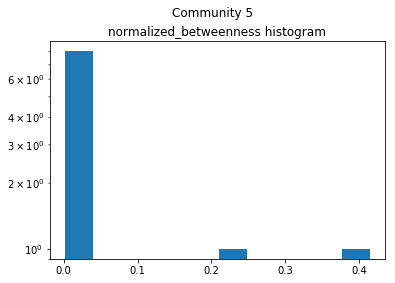

Vertex with the highest  normalized_betweenness : 
 [('José Emilio Suárez', 0.239), ('Semaan Gaby Eid', 0.417)]


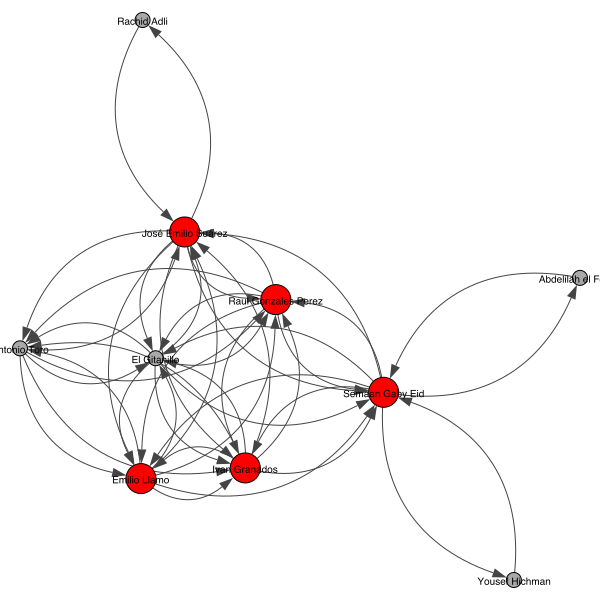

In [329]:
personalized_plots(sg5, 'normalized_betweenness', 0.2, 'Community 5')

### Closeness centrality

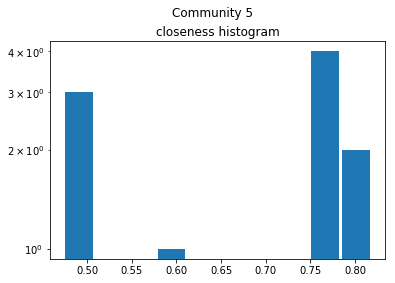

Vertex with the highest  closeness : 
 [('Emilio Llamo', 0.75), ('Ivan Granados', 0.75), ('Raul Gonzales Perez', 0.75), ('El Gitanillo', 0.75), ('José Emilio Suárez', 0.818), ('Semaan Gaby Eid', 0.818)]


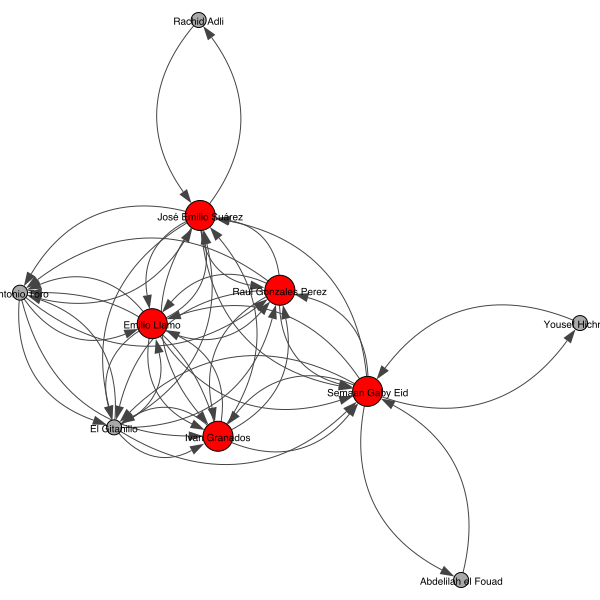

In [330]:
personalized_plots(sg5, 'closeness', 0.7, 'Community 5')

### Pagerank centrality

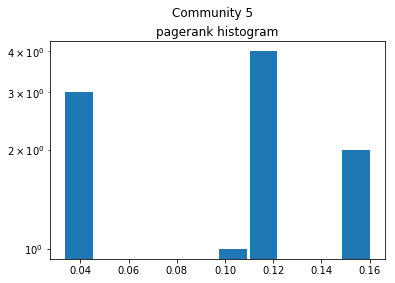

Vertex with the highest  pagerank : 
 [('Emilio Llamo', 0.122), ('Ivan Granados', 0.122), ('Raul Gonzales Perez', 0.122), ('El Gitanillo', 0.122), ('José Emilio Suárez', 0.149), ('Semaan Gaby Eid', 0.161)]


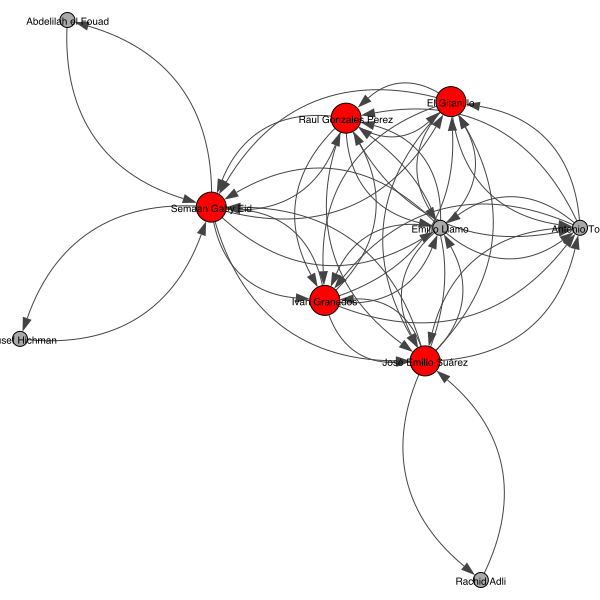

In [331]:
personalized_plots(sg5, 'pagerank', 0.12, 'Community 5')

### Eigenvector centrality

/Users/Giorgia/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

Weighted directed graph in eigenvector centrality at centrality.c:362



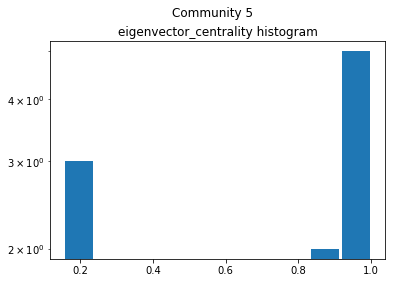

Vertex with the highest  eigenvector_centrality : 
 [('Antonio Toro', 0.843), ('Semaan Gaby Eid', 0.896), ('Emilio Llamo', 0.975), ('Ivan Granados', 0.975), ('Raul Gonzales Perez', 0.975), ('El Gitanillo', 0.975), ('José Emilio Suárez', 1.0)]


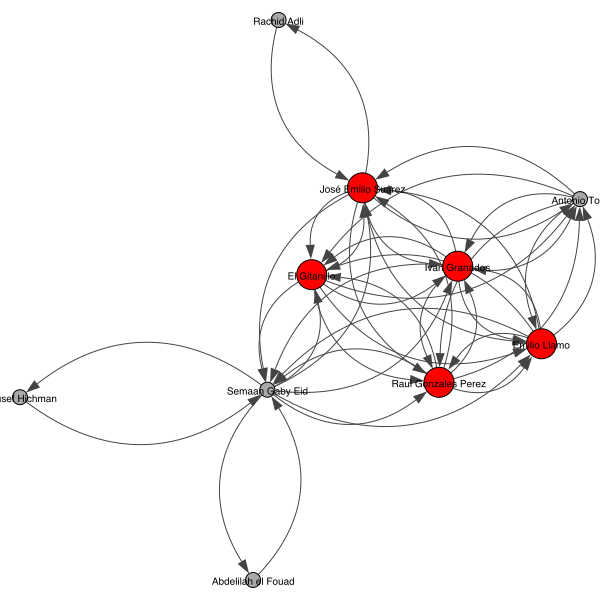

In [332]:
personalized_plots(sg5, 'eigenvector_centrality', 0.8, 'Community 5')

## Community Edge Betweenness 

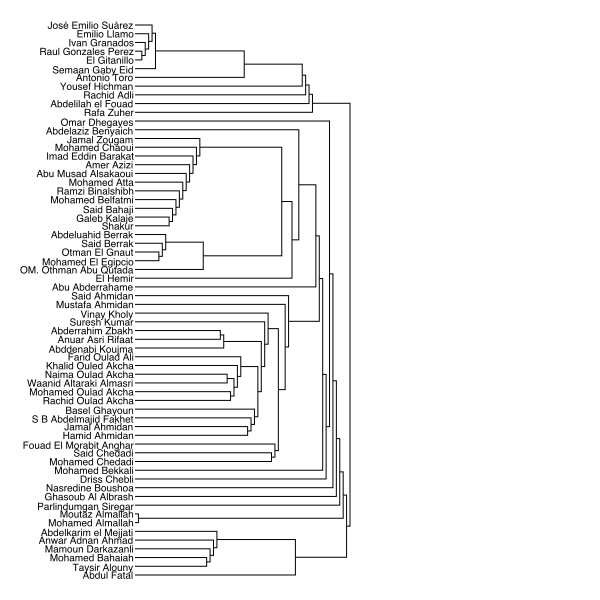

In [333]:
partition_edge = g.community_edge_betweenness()
ig.plot(partition_edge, 'images/community_edge_betweenness.pdf')

## Comparison of centrality measures

In [334]:
def print_comparison_table (graph):
    ranking_Degree, ranking_Betweenness, ranking_Closeness, ranking_Pagerank, ranking_Eigenvector = ranking(graph)
    
    print('Centrality measure of: ', str(graph["name"]))
    print('\n')
    print('Degree'.ljust(25) + 'Norm. Betweenness'.ljust(25) + 'Closeness'.ljust(25) + 'Pagerank'.ljust(25) + 'Eigenvector')
    print('\n')
    print(ranking_Degree[0][0].ljust(25) + ranking_Betweenness[0][0].ljust(25) + ranking_Closeness[0][0].ljust(25) + ranking_Pagerank[0][0].ljust(25) + ranking_Eigenvector[0][0])
    print(ranking_Degree[1][0].ljust(25) + ranking_Betweenness[1][0].ljust(25) + ranking_Closeness[1][0].ljust(25) + ranking_Pagerank[1][0].ljust(25) + ranking_Eigenvector[1][0])
    print(ranking_Degree[2][0].ljust(25) + ranking_Betweenness[2][0].ljust(25) + ranking_Closeness[2][0].ljust(25) + ranking_Pagerank[2][0].ljust(25) + ranking_Eigenvector[2][0])
    print(ranking_Degree[3][0].ljust(25) + ranking_Betweenness[3][0].ljust(25) + ranking_Closeness[3][0].ljust(25) + ranking_Pagerank[3][0].ljust(25) + ranking_Eigenvector[3][0])
    print(ranking_Degree[4][0].ljust(25) + ranking_Betweenness[4][0].ljust(25) + ranking_Closeness[4][0].ljust(25) + ranking_Pagerank[4][0].ljust(25) + ranking_Eigenvector[4][0])
    
def print_comparison_table_measure (graph):
    ranking_Degree, ranking_Betweenness, ranking_Closeness, ranking_Pagerank, ranking_Eigenvector = ranking(graph)
    
    print('Centrality measure of: ', str(graph["name"]))
    print('\n')
    print('Degree'.center(35) + 'Norm. Betweenness'.center(35) + 'Closeness'.center(35) + 'Pagerank'.center(35) + 'Eigenvector'.center(35))
    print('\n')
    print(ranking_Degree[0][0].ljust(25) + str(round(ranking_Degree[0][1], 3)).ljust(10) + ranking_Betweenness[0][0].ljust(25) + str(round(ranking_Betweenness[0][1], 3)).ljust(10) + ranking_Closeness[0][0].ljust(25) +  str(round(ranking_Closeness[0][1], 3)).ljust(10) + ranking_Pagerank[0][0].ljust(25) + str(round(ranking_Pagerank[0][1], 3)).ljust(10) + ranking_Eigenvector[0][0].ljust(25) + str(round(ranking_Eigenvector[0][1], 3)))
    print(ranking_Degree[1][0].ljust(25) + str(round(ranking_Degree[1][1], 3)).ljust(10) + ranking_Betweenness[1][0].ljust(25) + str(round(ranking_Betweenness[1][1], 3)).ljust(10) + ranking_Closeness[1][0].ljust(25) +  str(round(ranking_Closeness[1][1], 3)).ljust(10) + ranking_Pagerank[1][0].ljust(25) + str(round(ranking_Pagerank[1][1], 3)).ljust(10) + ranking_Eigenvector[1][0].ljust(25) + str(round(ranking_Eigenvector[1][1], 3)))
    print(ranking_Degree[2][0].ljust(25) + str(round(ranking_Degree[2][1], 3)).ljust(10) + ranking_Betweenness[2][0].ljust(25) + str(round(ranking_Betweenness[2][1], 3)).ljust(10) + ranking_Closeness[2][0].ljust(25) +  str(round(ranking_Closeness[2][1], 3)).ljust(10) + ranking_Pagerank[2][0].ljust(25) + str(round(ranking_Pagerank[2][1], 3)).ljust(10) + ranking_Eigenvector[2][0].ljust(25) + str(round(ranking_Eigenvector[2][1], 3)))
    print(ranking_Degree[3][0].ljust(25) + str(round(ranking_Degree[3][1], 3)).ljust(10) + ranking_Betweenness[3][0].ljust(25) + str(round(ranking_Betweenness[3][1], 3)).ljust(10) + ranking_Closeness[3][0].ljust(25) +  str(round(ranking_Closeness[3][1], 3)).ljust(10) + ranking_Pagerank[3][0].ljust(25) + str(round(ranking_Pagerank[3][1], 3)).ljust(10) + ranking_Eigenvector[3][0].ljust(25) + str(round(ranking_Eigenvector[3][1], 3)))
    print(ranking_Degree[4][0].ljust(25) + str(round(ranking_Degree[4][1], 3)).ljust(10) + ranking_Betweenness[4][0].ljust(25) + str(round(ranking_Betweenness[4][1], 3)).ljust(10) + ranking_Closeness[4][0].ljust(25) +  str(round(ranking_Closeness[4][1], 3)).ljust(10) + ranking_Pagerank[4][0].ljust(25) + str(round(ranking_Pagerank[4][1], 3)).ljust(10) + ranking_Eigenvector[4][0].ljust(25) + str(round(ranking_Eigenvector[4][1], 3)))

In [335]:
print_comparison_table_measure(g)

Centrality measure of:  g


               Degree                       Norm. Betweenness                      Closeness                           Pagerank                         Eigenvector            


Jamal Zougam             0.906     Semaan Gaby Eid          0.23      Mohamed Chaoui           0.529     Jamal Zougam             0.059     Jamal Zougam             1.0
Mohamed Chaoui           0.844     Mohamed Chaoui           0.191     Jamal Zougam             0.516     Imad Eddin Barakat       0.049     Imad Eddin Barakat       0.904
Imad Eddin Barakat       0.688     Abdeluahid Berrak        0.137     Jamal Ahmidan            0.496     Mohamed Chaoui           0.047     Mohamed Chaoui           0.794
Amer Azizi               0.562     Jamal Zougam             0.135     Abdeluahid Berrak        0.485     Amer Azizi               0.037     Amer Azizi               0.786
Said Berrak              0.531     Jamal Ahmidan            0.133     Said Berrak              0.485     Naima O

In [336]:
print_comparison_table_measure(sg1)

Centrality measure of:  sg1


               Degree                       Norm. Betweenness                      Closeness                           Pagerank                         Eigenvector            


Imad Eddin Barakat       0.438     Imad Eddin Barakat       0.189     Abu Musad Alsakaoui      0.727     Imad Eddin Barakat       0.13      Imad Eddin Barakat       1.0
Jamal Zougam             0.406     Amer Azizi               0.177     Mohamed Atta             0.667     Jamal Zougam             0.115     Jamal Zougam             0.996
Amer Azizi               0.406     Abu Musad Alsakaoui      0.103     Shakur                   0.667     Amer Azizi               0.102     Amer Azizi               0.85
Mohamed Chaoui           0.375     Mohamed Chaoui           0.102     Ramzi Binalshibh         0.64      Mohamed Belfatmi         0.088     Mohamed Belfatmi         0.756
Mohamed Belfatmi         0.344     Jamal Zougam             0.072     Mohamed Chaoui           0.593     Mohame

In [337]:
print_comparison_table_measure(sg2)

Centrality measure of:  sg2


               Degree                       Norm. Betweenness                      Closeness                           Pagerank                         Eigenvector            


Naima Oulad Akcha        0.438     Naima Oulad Akcha        0.377     Naima Oulad Akcha        0.792     Naima Oulad Akcha        0.114     Naima Oulad Akcha        1.0
Abderrahim Zbakh         0.375     Abderrahim Zbakh         0.263     Abderrahim Zbakh         0.731     Abderrahim Zbakh         0.1       Abderrahim Zbakh         0.946
Jamal Ahmidan            0.344     Jamal Ahmidan            0.193     Jamal Ahmidan            0.704     Jamal Ahmidan            0.089     Jamal Ahmidan            0.917
Hamid Ahmidan            0.312     Hamid Ahmidan            0.088     Hamid Ahmidan            0.679     Hamid Ahmidan            0.077     Hamid Ahmidan            0.906
Vinay Kholy              0.25      Mohamed Oulad Akcha      0.012     Vinay Kholy              0.633     Vinay

In [338]:
print_comparison_table_measure(sg3)

Centrality measure of:  sg3


               Degree                       Norm. Betweenness                      Closeness                           Pagerank                         Eigenvector            


Mohamed El Egipcio       0.156     Mohamed El Egipcio       0.524     Mohamed El Egipcio       0.7       Mohamed El Egipcio       0.214     Mohamed El Egipcio       1.0
Mohamed Chedadi          0.125     Mohamed Chedadi          0.333     Abdeluahid Berrak        0.636     Mohamed Chedadi          0.181     Abdeluahid Berrak        0.829
Abdeluahid Berrak        0.094     Abdeluahid Berrak        0.095     Otman El Gnaut           0.636     Abdeluahid Berrak        0.131     Otman El Gnaut           0.829
Otman El Gnaut           0.094     Otman El Gnaut           0.095     Mohamed Chedadi          0.583     Otman El Gnaut           0.131     Mohamed Chedadi          0.784
Fouad El Morabit Anghar  0.062     Fouad El Morabit Anghar  0.095     Fouad El Morabit Anghar  0.583     Mouta

In [339]:
print_comparison_table_measure(sg4)

Centrality measure of:  sg4


               Degree                       Norm. Betweenness                      Closeness                           Pagerank                         Eigenvector            


Abdelkarim el Mejjati    0.188     Abdelkarim el Mejjati    0.554     Abdelkarim el Mejjati    0.727     Taysir Alouny            0.167     Taysir Alouny            1.0
Taysir Alouny            0.156     Abdelaziz Benyaich       0.25      Taysir Alouny            0.571     Abdelkarim el Mejjati    0.167     Mohamed Bahaiah          0.967
Anwar Adnan Ahmad        0.125     Taysir Alouny            0.25      Anwar Adnan Ahmad        0.571     Mohamed Bahaiah          0.135     Abdelkarim el Mejjati    0.89
Mamoun Darkazanli        0.125     Anwar Adnan Ahmad        0.018     Mamoun Darkazanli        0.571     Abdelaziz Benyaich       0.131     Mamoun Darkazanli        0.789
Mohamed Bahaiah          0.125     Mamoun Darkazanli        0.018     Abdelaziz Benyaich       0.533     Anwar 

In [340]:
print_comparison_table_measure(sg5)

Centrality measure of:  sg5


               Degree                       Norm. Betweenness                      Closeness                           Pagerank                         Eigenvector            


José Emilio Suárez       0.219     Semaan Gaby Eid          0.417     José Emilio Suárez       0.818     Semaan Gaby Eid          0.161     José Emilio Suárez       1.0
Semaan Gaby Eid          0.219     José Emilio Suárez       0.239     Semaan Gaby Eid          0.818     José Emilio Suárez       0.149     Ivan Granados            0.975
Emilio Llamo             0.188     Emilio Llamo             0.017     Emilio Llamo             0.75      Ivan Granados            0.122     El Gitanillo             0.975
Ivan Granados            0.188     Ivan Granados            0.017     Ivan Granados            0.75      Raul Gonzales Perez      0.122     Emilio Llamo             0.975
Raul Gonzales Perez      0.188     Raul Gonzales Perez      0.017     Raul Gonzales Perez      0.75      El Gi

## Distributions

In [341]:
def plot_distributions(measure):
    if measure == "degree":
        f_g   = import_measure(g)[0]
        f_sg1 = import_measure(sg1)[0]
        f_sg2 = import_measure(sg2)[0]
        f_sg3 = import_measure(sg3)[0]
        f_sg4 = import_measure(sg4)[0]
        f_sg5 = import_measure(sg5)[0]
    if measure == "normalized_betweenness":
        f_g    = import_measure(g)[1]
        f_sg1 = import_measure(sg1)[1]
        f_sg2 = import_measure(sg2)[1]
        f_sg3 = import_measure(sg3)[1]
        f_sg4 = import_measure(sg4)[1]
        f_sg5 = import_measure(sg5)[1]
    if measure == "closeness":
        f_g   = import_measure(g)[2]
        f_sg1 = import_measure(sg1)[2]
        f_sg2 = import_measure(sg2)[2]
        f_sg3 = import_measure(sg3)[2]
        f_sg4 = import_measure(sg4)[2]
        f_sg5 = import_measure(sg5)[2]
    if measure == "pagerank":
        f_g   = import_measure(g)[3]
        f_sg1 = import_measure(sg1)[3]
        f_sg2 = import_measure(sg2)[3]
        f_sg3 = import_measure(sg3)[3]
        f_sg4 = import_measure(sg4)[3]
        f_sg5 = import_measure(sg5)[3]
    if measure == "eigenvector_centrality":
        f_g   = import_measure(g)[4]
        f_sg1 = import_measure(sg1)[4]
        f_sg2 = import_measure(sg2)[4]
        f_sg3 = import_measure(sg3)[4]
        f_sg4 = import_measure(sg4)[4]
        f_sg5 = import_measure(sg5)[4]
        
    x = np.arange(10)

    fig = plt.figure()
    ax = plt.subplot(111)

    ax.plot(f_g,   label='network')
    ax.plot(f_sg1, label='community 1')
    ax.plot(f_sg2, label='community 2')
    ax.plot(f_sg3, label='community 3')
    ax.plot(f_sg4, label='community 4')
    ax.plot(f_sg5, label='community 5')

    # Shrink current axis by 20%
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Legend to the right of the current axis
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title('Distribution '+ measure)
    plt.xlabel(measure)
    plt.ylabel('persons')
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')

    
    plt.savefig('images/' + measure + '-distribution.pdf')
    plt.show()      

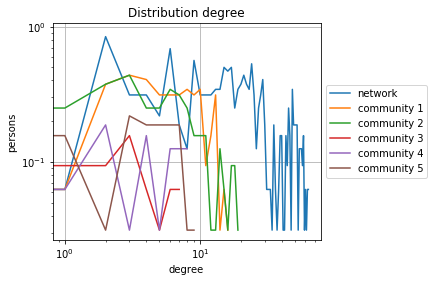

In [342]:
plot_distributions('degree')

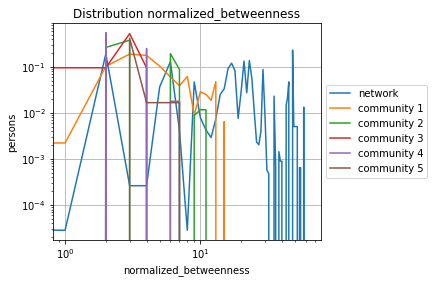

In [343]:
plot_distributions('normalized_betweenness')

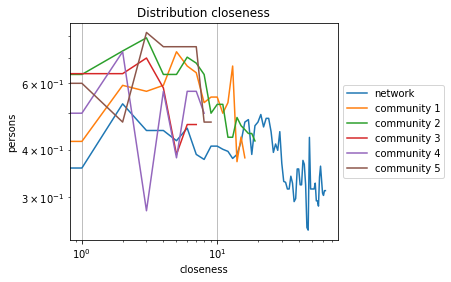

In [344]:
plot_distributions('closeness')

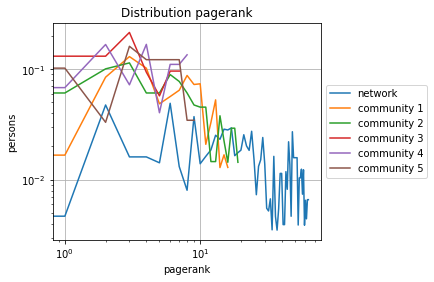

In [345]:
plot_distributions('pagerank')

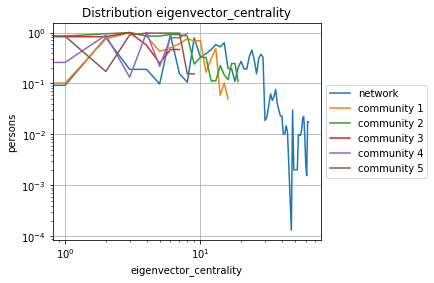

In [346]:
plot_distributions('eigenvector_centrality')

## Further bombings spur investigation

**Individuals suspected of being the perpetrators of the Madrid and AVE attacks**:  
- *Jamal Zougam* – guilty and given a 50,000 year jail sentence, was arrested two days after the March 2004 attacks.  (http://newsimg.bbc.co.uk/media/images/40530000/jpg/_40530545_1zougamap203cred.jpg)  
- *Sarhane B Abdelmajid* – The suspected ringleader of the plot.  
- *Jamal Ahmidan* – cousin of Hamid Ahmidan.
- *Hamid Ahmidan* – found guilty and given between a 23- to 25-year sentence. Moroccan and a cousin of Jamal Ahmidan, these men took part in drug trafficking. His release date from prison is November 2030.  
- *Fouad El Morabit Anghar* – guilty, 12-year sentence was being held in March 2004 for allegedly belonging to the Madrid terror cell, he also had contacts with Rabei Osman. His release date is set for November 2019. The student has been provisionally charged with collaborating with a terrorist organisation.
Investigators say he was in telephone contact before and on the day of the attacks with most of the suspects who have either been arrested or who are now dead.  
- *Nasredine Boushoa* – guilty, 3-year sentence, he was allegedly helped forge fake documents. Spanish prosecutors had asked for 13 years in jail. Released on November 2010.  
Accused of receiving nine telephone calls from key suspects days before the attacks. He was released from custody on 15 February 2005 on 6,000-euro ($7,900) bail. He has been ordered to present himself periodically at court.


- *Antonio Toro* – Spanish, detained for second time on 2 December, 2004. The former miner is accused of supplying explosive substances and collaboration with an armed group.

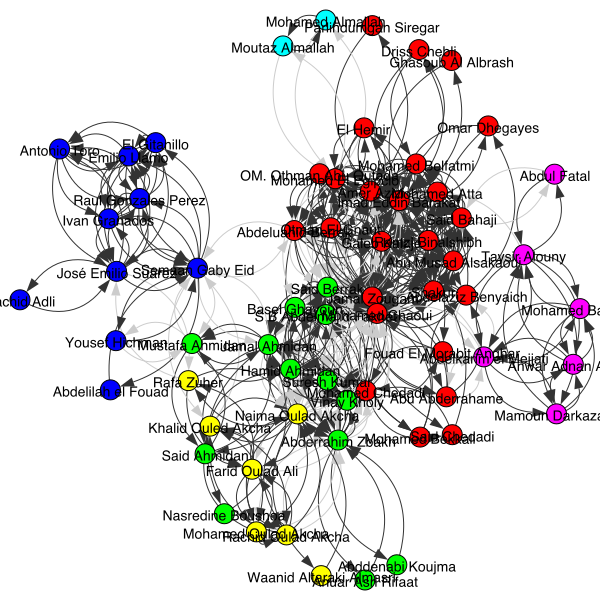

In [347]:
ig.plot(g.community_infomap())

In [348]:
## Isolated nodes
labels = g.vs["label"]
n = open("data/madrid-names.dat")
names = list()
for el in n:
    names.append(el.replace('\n', '').replace('"', ''))

isolated_nodes = list(set(names) - set(labels))
print(isolated_nodes)
print(len(isolated_nodes))

['Alí Amrous', 'Abdelhalak Bentasser', 'Mohamad Bard Ddin Akkab', 'Sanel Sjekirika', 'Faisal Alluch', 'Abu Zubaidah']
6


In [349]:
def mean_distributions(graph):    
    degree, betweenness, closeness, pagerank, eigenvector = import_measure(graph)
   
    print('Centrality distribution of graph ', str(graph["name"]))
    print('\n')
    print('Mean Degree Distribution: '.ljust(35), str(round(np.mean(degree), 3)).ljust(20))
    print('Mean Betweenness Distribution: '.ljust(35), str(round(np.mean(betweenness), 3)).ljust(20))
    print('Mean Closeness Distribution: '.ljust(35), str(round(np.mean(closeness), 3)).ljust(20))
    print('Mean Pagerank Distribution: '.ljust(35), str(round(np.mean(pagerank), 3)).ljust(20))
    print('Mean Eigenvector Distribution: '.ljust(35), str(round(np.mean(eigenvector), 3)).ljust(20))

In [350]:
mean_distributions(g)

Centrality distribution of graph  g


Mean Degree Distribution:           0.237               
Mean Betweenness Distribution:      0.028               
Mean Closeness Distribution:        0.376               
Mean Pagerank Distribution:         0.016               
Mean Eigenvector Distribution:      0.18                


In [351]:
mean_distributions(sg1)

Centrality distribution of graph  sg1


Mean Degree Distribution:           0.254               
Mean Betweenness Distribution:      0.055               
Mean Closeness Distribution:        0.546               
Mean Pagerank Distribution:         0.059               
Mean Eigenvector Distribution:      0.502               


In [352]:
mean_distributions(sg2)

Centrality distribution of graph  sg2


Mean Degree Distribution:           0.184               
Mean Betweenness Distribution:      0.048               
Mean Closeness Distribution:        0.56                
Mean Pagerank Distribution:         0.05                
Mean Eigenvector Distribution:      0.512               


In [353]:
mean_distributions(sg3)

Centrality distribution of graph  sg3


Mean Degree Distribution:           0.086               
Mean Betweenness Distribution:      0.143               
Mean Closeness Distribution:        0.558               
Mean Pagerank Distribution:         0.125               
Mean Eigenvector Distribution:      0.648               


In [354]:
mean_distributions(sg4)

Centrality distribution of graph  sg4


Mean Degree Distribution:           0.104               
Mean Betweenness Distribution:      0.121               
Mean Closeness Distribution:        0.515               
Mean Pagerank Distribution:         0.111               
Mean Eigenvector Distribution:      0.594               


In [355]:
mean_distributions(sg5)

Centrality distribution of graph  sg5


Mean Degree Distribution:           0.144               
Mean Betweenness Distribution:      0.072               
Mean Closeness Distribution:        0.666               
Mean Pagerank Distribution:         0.1                 
Mean Eigenvector Distribution:      0.712               


In [356]:
np.mean(g.es['weight'])

1.1604938271604939

In [357]:
np.mean(sg1.es['weight'])

1.4782608695652173

In [358]:
np.mean(sg2.es['weight'])

1.0

In [359]:
np.mean(sg3.es['weight'])

1.0

In [360]:
np.mean(sg4.es['weight'])

1.1333333333333333

In [361]:
np.mean(sg5.es['weight'])

1.0